In [1]:
import signalsnap as snp
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt

# Polyspectra from timestamps

Data cannot only be given in continuous form, but also as a table of timestamps. This is for example case, whenever only singular events are triggered by a more complex apparatus. We are then given the time at which these events occur and from that want to find out more about the apparatus. In the theory of so called random-time sampling it idea is implemented by probing the state of the apparatus at random times, where we now the probability of an event is proportional to some measure of the apparatus.
Here, we are going to simulate the apparatus first and then use random-time sampling to arrive a collection of timestamps containing information about the original signal. We will see that the information is preserved.

## Generation of test data

Let's say the measure of the apparatus yields non-Gaussian noise.
We are generating non-Gaussian noise from white noise:
    1. Generate white noise
    2. Apply a Lorentzian filter to create a peak at frequency $f_c$
    3. Take the exponential of the noise in time domain to mix the signal with itself and ensure it is positive everywhere.

In [16]:
t = np.linspace(0,0.05,int(25e5))
dt = t[1] - t[0]
f_max = 1/(dt)/2
print('f_Nyquist =', f_max / 1e6, 'MHz')

white_noise_1 = np.random.normal(size=len(t))

freq = rfftfreq(len(t), t[1]-t[0])
f_c = 0.05e6 # Hz
f_1 = 0.4e7
P_1 = 1
filter_func_1 = P_1/(np.pi * f_c) / (1 + ((freq-f_1)/f_c)**2)

filtered_noise = np.exp(1e4*(irfft(np.sqrt(filter_func_1) * rfft(white_noise_1))))

f_Nyquist = 24.999989999999997 MHz


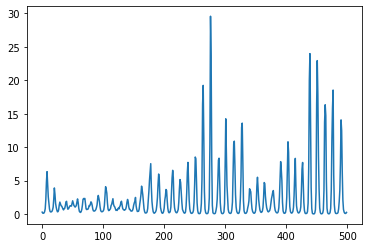

In [17]:
plt.plot((filtered_noise[:int(5e2)]))

Actual T_window: 1.0000004000001601e-05
Maximum frequency: 24999989.999999996
Number of points: 251


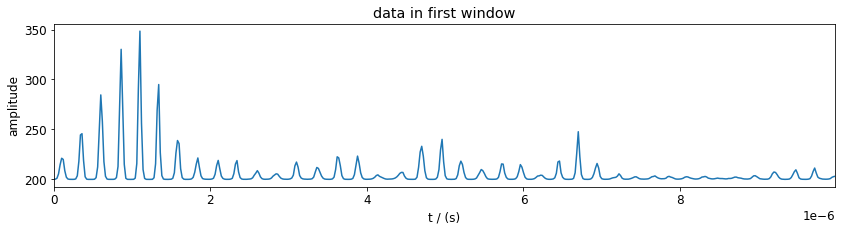

chunk shape:  500


In [10]:
spec = snp.Spectrum(delta_t=dt, data=filtered_noise)
T_window = 0.00001
f, s, serr = spec.calc_spec([2,3,4], f_max=f_max, T_window=T_window, m=5, backend='opencl')

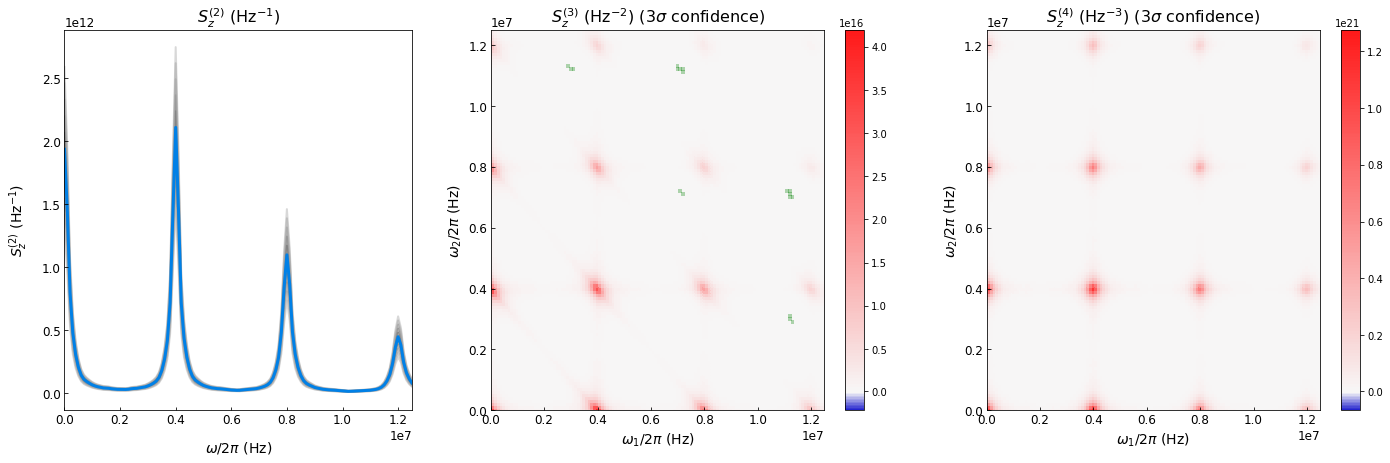

In [11]:
fig = spec.plot([2,3,4], f_max=1.25e7, green_alpha=0.3, sigma=3)

## Generate of timestamps by randomly sampling the data

To get from the continuous trace to a collection of timestamps we are using so called random-time sampling for a conversion.
In random-time sampling the probability of receiving a timestamp at each point in time will be proportional to the value of the noise at that point; we receive more timestamps at times of stronger noise. This also means that information about the signal lies in the distribution of the timestamps.

In [18]:
clicks = filtered_noise/filtered_noise.max() > np.random.rand(filtered_noise.shape[0])
timestamps = t[clicks]
print(len(timestamps))

1457


In [19]:
RSspec = snp.Spectrum(data=timestamps, delta_t=dt)

In [20]:
T_window = 0.00001
f, s, serr = RSspec.calc_spec_poisson([2,3,4], f_max=f_max, T_window=T_window, m=5, backend='opencl')

number of points: 251
delta f: 99999.99999999999
Number of points: 251


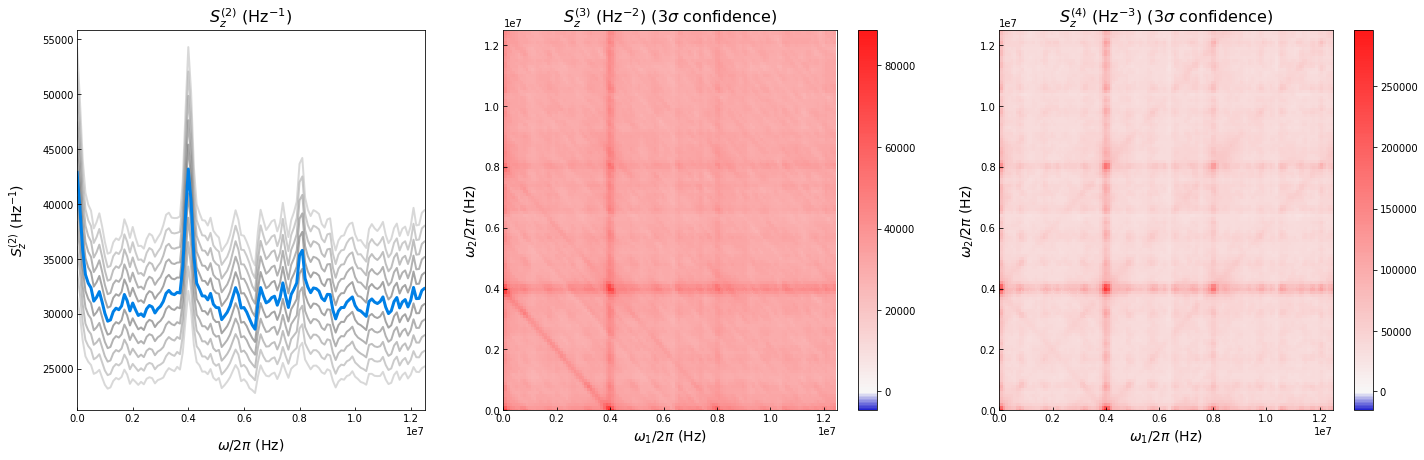

In [21]:
fig = RSspec.plot([2,3,4], f_max=1.25e7, green_alpha=0.3, sigma=3)